<img src = "Applied_Data_Science_Capstone.png" alt="IBM Course Logo" width = 100 align=right>

<h1 align=left><font size = 5>Identifying New Dealer Locations for an OEM</font></h1>
  
<i align=left><font size = 3>IBM Applied Data Science Capstone Project | Amol Sangeet</font></i>

## Introduction

In this document, I create and present my Capstone project for IBM's Data Science Professional Certification on Coursera. The project objective is to help an auto OEM scout for and identify potential dealership locations by following competitors, as well as, using other proxy information like availability of banking facilities, hotels and other places indicative of commercial activity and financial well-being.


<a id='home'></a>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

A. <a href="#itemA">The Business Problem & Data Requirement</a>

B. <a href="#itemB">Methodology</a>
    
1. <a href="#item1">Load and map the Honda Cars India Dealers Network</a>

2. <a href="#item2">Load the Maharashtra Districts data</a>

3. <a href="#item3">Fetching and Using Foursquare Data</a>

4. <a href="#item4">Cluster Neighbourhoods</a>

C. <a href="#itemC">Results & Discussion</a>
    

D. <a href="#itemD">Conclusion</a>
</font>
</div>

<a id='itemA'></a>

## A. The Business Problem & Data Requirement

<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

Companies that need to enter new geographies or increase penetration in existing geographies have to routinely address the problem of identifying locations for new dealerships or sales outlets. While geographic gaps can easliy be identified on the map, the target locations should also have business potential for the company as represented by current market size, competitor sales, overall economic environment etc.

This project tries to address this problem for an auto OEM by identifying locations for setting up new dealerships in the 
state of Maharashtra, India, where it is seeking to increase its market penetration.

The approach adopted for this is to collect data on the presence of competitors and shortlist locations where the competitors are present but the OEM is not. The OEM that is used for the project is Honda Cars India. While Honda already has a presence in Maharashtra, it needs to expand its dealership network within the state. For this, let's assume that it has decided to track the presence of other OEMs indicating where the market potential is. 

However, every location where competitors have a dealer may not result in business for Honda. It would also need more data on other factors like, say, availability of banking facilities around the target location, income levels of the local population, wealth generation potential etc. For the purpose of this project the data sources are limited to the Foursquare API, OEM websites, and Wikipedia. However, it is understood that in practice, the OEM may have and use data on rival dealer sales, demographic information etc. which is not available on Foursquare API or on the OEM websites.

Hence, the data that we will sift through is other auto dealer locations, bank branches, hotels, restaurants, and perhaps other retail outlets, if any, and using the k-means clustering algorithm  shortlist locations which have a rival dealers but no Honda dealer, and venues from categories like banks, hotels etc. within a 3 km radius.


Before we get the data and start exploring it, let's download all the libraries that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed Geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#from shapely.geometry import Point, Polygon

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't installed Folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='itemB'></a>

## B. Methodology
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

1. We will first load the Honda dealer network data obtained from the company's India website.
  
  
2. Next, we will load data for each district of Maharashtra which will be filtered to shortlist districts with significant market potential.
  
  
3. Next we will fetch dealer data for other OEMs from Foursquare API for each of the shortlisted districts.
  
  
4. For the Honda, as well as, other dealers we need to get standardized addresses which will facilitate geographical comparison. This will be done using reverse geocoding with the **geolocator.reverse()** funtion in **GeoPy**.
  
  
5. For each of the standardized addresses for other OEM dealers, we will use the **search** function in the **Foursquare API** to explore the neighbourhood for other venue categories that would represent, and be a proxy for, economic activity, lifestyle, and availability of finance. For economic activity, we shall explore Office venues and Hotels; for lifestyle data, we shall use restaurants and nightlife category venues; and, for access to finance we shall look for presence of leading private sector banks. This entire activity would indicate the market potential in the neighbourhood.
  
  
6. Combining all this data, we shall prepare it for clustering by first grouping the data based on addresses and use **one-hot encoding** to get the totals of venues per address. Then, we shall perform ***k*-means clustering** to identify geographical clusters which the company should target for new dealers. While we need 2-3 broad categories, we can use the Elbow Method to confirm whether this would be an appropriate number.
  
  
7. We will end with understanding how this project, if required, can be applied in a live situation and what additional data could be useful.
  
  

<a id='item1'></a>

### 1. Honda Cars India Ltd. data
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

#### Load the Honda Cars India dealer network dataset

This has been scraped from the Honda website and downloaded into a CSV file which will be used as the source.

In [2]:
df_honda = pd.read_csv('G:\Google\Google Drive\Learning\ML\Python\Honda-Dealers.csv')
df_honda.head()

Dealer Code       Dealer Name          Dealer Type       Lat      Long  \
0       DD313  Ring Road Honda   Showroom & Workshop  28.68060  77.08994   
1       DD020      Prime Honda   Showroom & Workshop  28.64599  77.33332   
2       DD109   Courtesy Honda   Showroom & Workshop  30.71387  76.80975   
3       DD004   Prestige Honda   Showroom & Workshop  31.29380  75.65388   
4       DD024   Prestige Honda   Showroom & Workshop  31.60418  74.93701   

   Distance                      Company  \
0       NaN         Sugoi Motors pvt ltd   
1       NaN       Capital Cars Pvt. Ltd.   
2       NaN  Lally Automobiles Pvt. Ltd.   
3       NaN            Lally Motors Ltd.   
4       NaN            Lally Motors Ltd.   

                                             Address        City  \
0            A-2 Udyog Nagar Indl. Area, Rohtak Road       DELHI   
1   Ansal Plaza, Main Link Road (Opp. Dabur Facto...   GHAZIABAD   
2                  Plot No. 6., Indl. Area Phase - I  CHANDIGARH   
3                                   Pragpur,G.T.Road   JALANDHAR   
4                               G.T ROAD, SULTANWIND    AMRITSAR   

                                               Email  \
0                               telemktg@rrhonda.com   
1  crmsalesvaishali@primehonda.comcustomercare@pr...   
2  saleschd@lallyautomobiles.netsalesheadchd@lall...   
3       salesjal@lallymotors.netripu@lallymotors.net   
4       salesamr@lallymotors.netripu@lallymotors.net   

                                 Phone            Fax           SMS  
0             01145520000, 01145540000  011- 45540050   SMS Address  
1  7290055379, 7375004989, 01204184200            NaN   SMS Address  
2                           1723067777   0172-3067700   SMS Address  
3                           1813067777   0181-3067700   SMS Address  
4                           1833067777   0183-3067770   SMS Address

We need a standardized dealer address which will be comparable with other addresses generated during this process.

In [148]:
dlr_addresses = list()
for lat, lng in zip(df_honda['Lat'], df_honda['Long']):
    area = geolocator.reverse([lat,lng])
    dlr_address = area.raw.get('address').get('suburb', area.raw.get('address').get('road')), area.raw.get('address').get('county'), area.raw.get('address').get('state_district')
    dlr_address = ', '.join(str(i) or '' for i in dlr_address)
    dlr_addresses.append(dlr_address)

df_honda['dlr_address'] = dlr_addresses
df_honda.head()

Dealer Code       Dealer Name          Dealer Type       Lat      Long  \
0       DD313  Ring Road Honda   Showroom & Workshop  28.68060  77.08994   
1       DD020      Prime Honda   Showroom & Workshop  28.64599  77.33332   
2       DD109   Courtesy Honda   Showroom & Workshop  30.71387  76.80975   
3       DD004   Prestige Honda   Showroom & Workshop  31.29380  75.65388   
4       DD024   Prestige Honda   Showroom & Workshop  31.60418  74.93701   

   Distance                      Company  \
0       NaN         Sugoi Motors pvt ltd   
1       NaN       Capital Cars Pvt. Ltd.   
2       NaN  Lally Automobiles Pvt. Ltd.   
3       NaN            Lally Motors Ltd.   
4       NaN            Lally Motors Ltd.   

                                             Address        City  \
0            A-2 Udyog Nagar Indl. Area, Rohtak Road       DELHI   
1   Ansal Plaza, Main Link Road (Opp. Dabur Facto...   GHAZIABAD   
2                  Plot No. 6., Indl. Area Phase - I  CHANDIGARH   
3                                   Pragpur,G.T.Road   JALANDHAR   
4                               G.T ROAD, SULTANWIND    AMRITSAR   

                                               Email  \
0                               telemktg@rrhonda.com   
1  crmsalesvaishali@primehonda.comcustomercare@pr...   
2  saleschd@lallyautomobiles.netsalesheadchd@lall...   
3       salesjal@lallymotors.netripu@lallymotors.net   
4       salesamr@lallymotors.netripu@lallymotors.net   

                                 Phone            Fax           SMS  \
0             01145520000, 01145540000  011- 45540050   SMS Address   
1  7290055379, 7375004989, 01204184200            NaN   SMS Address   
2                           1723067777   0172-3067700   SMS Address   
3                           1813067777   0181-3067700   SMS Address   
4                           1833067777   0183-3067770   SMS Address   

                                         dlr_address  
0       Udyog Vihar, Punjabi Bagh Tehsil, West Delhi  
1                         Kaushambi, Ghaziabad, None  
2                             None, None, Chandigarh  
3                None, Jalandhar I Tahsil, Jalandhar  
4  GT Road; Sher Shah Suri Marg, Amritsar II Tahs...

In [3]:
df_honda.dtypes

Dealer Code     object
Dealer Name     object
Dealer Type     object
Lat            float64
Long           float64
Distance       float64
Company         object
Address         object
City            object
Email           object
Phone           object
Fax             object
SMS             object
dtype: object

In [4]:
df_honda.shape
print('There are', df_honda.shape[0], 'dealers in the dataset.')

There are 383 dealers in the dataset.


#### Plotting all the Honda dealers on the India map

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>mh_explorer</em>, as shown below.

In [5]:
address = 'Maharashtra, India'

geolocator = Nominatim(user_agent="mh_explorer")
location = geolocator.geocode(address)
MH_latitude = location.latitude
MH_longitude = location.longitude
print('The geograpical coordinate of Maharashtra, India are {}, {}.'.format(MH_latitude, MH_longitude))

The geograpical coordinate of Maharashtra, India are 19.531932, 76.0554568.


In [6]:
from folium import plugins
honda_map = folium.Map(location=[MH_latitude+1, MH_longitude+5], zoom_start=4)

# instantiate a mark cluster object for the incidents in the dataframe
# dmarkers = plugins.MarkerCluster().add_to(honda_map)


# add the catogories as blue circle markers
for lat, lng, label, name, addr in zip(
    df_honda.Lat, 
    df_honda.Long, 
    df_honda['Dealer Type'], 
    df_honda['Dealer Name'], 
    df_honda['City']):
    
    if label == "Workshop":
        clr = 'green'
    elif label == 'Showroom & Workshop':
        clr = 'red'
    else: clr = 'yellow'
    
    tag = str(name).strip() + ', ' + str(addr).title()
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color=clr,
        popup=folium.Popup(tag),
        fill = True,
        fill_color=clr,
        fill_opacity=0.6
#     ).add_to(dmarkers) #if using a MarkerCluster
    ).add_to(honda_map)

# display map
honda_map

Now that we know where Honda has its dealers, let's being to identify where it needs to have new ones.

  <a id='item2'></a>

### 2. Load Data on Maharashtra Districts
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

#### Get the list of districts and related details from Wikipedia

In [7]:
urlMH = 'https://en.wikipedia.org/wiki/List_of_districts_of_Maharashtra'
dfs = pd.read_html(urlMH)
df_raw = dfs[1]
df_raw.head()

No        Name Code      Formed Headquarters AdministrativeDivision  \
0  1  Ahmednagar   AH  1 May 1960   Ahmednagar                 Nashik   
1  2       Akola   AK  1 May 1960        Akola               Amravati   
2  3    Amravati   AM  1 May 1960     Amravati               Amravati   
3  4  Aurangabad   AU  1 May 1960   Aurangabad             Aurangabad   
4  5        Beed   BI  1 May 1960         Beed             Aurangabad   

   Area (km2)  Population (2011 Census) Population(2001 census)  \
0     17413.0                 4543159.0                 4088077   
1      5417.0                 1813906.0                 1818617   
2     12626.0                 2888445.0                 2606063   
3     10100.0                 3701282.0                 2897013   
4     10439.0                 2585049.0                 2161250   

  % of StatePopulation  Density(per km2)  Urban (%)  Literacy (%)  Sex ratio  \
0                  NaN            234.77      19.67         80.22      941.0   
1                  NaN            300.78      44.04         88.05      938.0   
2                  NaN            206.40      34.50         82.50      838.0   
3                  NaN            286.83      37.53         61.15      924.0   
4                  NaN            207.04      17.91         68.00      936.0   

  Tehsils            Source  
0      14  District website  
1       7  District website  
2      14  District website  
3       9  District website  
4      11  District website

#### Clean and retain only the relevant data

In [8]:
df_MH = df_raw[['Name', 'Headquarters', 'Population(2001 census)', 'Urban (%)']]
df_MH.columns = ['Name', 'HQ', 'Population', 'Urban%']
df_MH = df_MH[df_MH['Name'] != "-"]
df_MH['Population'] = df_MH['Population'].str.replace(r'\(2011\)', '')
df_MH['Population'] = df_MH['Population'].str.replace(r',', '')
df_MH

Name          HQ Population  Urban%
0        Ahmednagar  Ahmednagar    4088077   19.67
1             Akola       Akola    1818617   44.04
2          Amravati    Amravati    2606063   34.50
3        Aurangabad  Aurangabad    2897013   37.53
4              Beed        Beed    2161250   17.91
5          Bhandara    Bhandara    1135835   15.44
6               NaN         NaN        NaN     NaN
7          Buldhana    Buldhana    2232480   21.20
8        Chandrapur  Chandrapur    2071101   32.11
9             Dhule       Dhule    1707947   26.11
10       Gadchiroli  Gadchiroli     970294    6.93
11           Gondia      Gondia    1200151   11.95
12          Hingoli     Hingoli     987160   15.20
13          Jalgaon     Jalgaon    3679936   71.40
14            Jalna       Jalna    1612357   19.09
15         Kolhapur    Kolhapur    3515413   29.65
16            Latur       Latur    2080285   23.57
17      Mumbai City      Mumbai    3326837  100.00
18  Mumbai Suburban      Bandra    8587000  100.00
19           Nagpur      Nagpur    4051444   64.33
20           Nanded      Nanded    2876259   28.29
21        Nandurbar   Nandurbar    1309135   15.50
22           Nashik      Nashik    4993796   38.80
23        Osmanabad   Osmanabad    1486586   15.70
24          Palghar     Palghar    2990116   50.00
25         Parbhani    Parbhani    1527715   31.80
26             Pune        Pune    7224224   58.10
27           Raigad      Alibag    2207929   24.20
28        Ratnagiri   Ratnagiri    1696777   11.30
29           Sangli      Sangli    2583524   24.50
30           Satara      Satara    2796906   14.20
31       Sindhudurg        Oros     868825    9.50
32          Solapur     Solapur    3849543   31.80
33            Thane       Thane    8131849   72.58
34           Wardha      Wardha    1230640   25.17
35           Washim      Washim    1020216   17.49
36         Yavatmal    Yavatmal    2077144   18.60

Check dataframe size and column datatypes:

In [9]:
df_MH.dropna(axis=0, inplace=True)
df_MH.reset_index(drop=True)

Name          HQ Population  Urban%
0        Ahmednagar  Ahmednagar    4088077   19.67
1             Akola       Akola    1818617   44.04
2          Amravati    Amravati    2606063   34.50
3        Aurangabad  Aurangabad    2897013   37.53
4              Beed        Beed    2161250   17.91
5          Bhandara    Bhandara    1135835   15.44
6          Buldhana    Buldhana    2232480   21.20
7        Chandrapur  Chandrapur    2071101   32.11
8             Dhule       Dhule    1707947   26.11
9        Gadchiroli  Gadchiroli     970294    6.93
10           Gondia      Gondia    1200151   11.95
11          Hingoli     Hingoli     987160   15.20
12          Jalgaon     Jalgaon    3679936   71.40
13            Jalna       Jalna    1612357   19.09
14         Kolhapur    Kolhapur    3515413   29.65
15            Latur       Latur    2080285   23.57
16      Mumbai City      Mumbai    3326837  100.00
17  Mumbai Suburban      Bandra    8587000  100.00
18           Nagpur      Nagpur    4051444   64.33
19           Nanded      Nanded    2876259   28.29
20        Nandurbar   Nandurbar    1309135   15.50
21           Nashik      Nashik    4993796   38.80
22        Osmanabad   Osmanabad    1486586   15.70
23          Palghar     Palghar    2990116   50.00
24         Parbhani    Parbhani    1527715   31.80
25             Pune        Pune    7224224   58.10
26           Raigad      Alibag    2207929   24.20
27        Ratnagiri   Ratnagiri    1696777   11.30
28           Sangli      Sangli    2583524   24.50
29           Satara      Satara    2796906   14.20
30       Sindhudurg        Oros     868825    9.50
31          Solapur     Solapur    3849543   31.80
32            Thane       Thane    8131849   72.58
33           Wardha      Wardha    1230640   25.17
34           Washim      Washim    1020216   17.49
35         Yavatmal    Yavatmal    2077144   18.60

In [10]:
print(df_MH.dtypes)
print(df_MH.shape)

Name           object
HQ             object
Population     object
Urban%        float64
dtype: object
(36, 4)


Change the datatype of Population column to numeric to facilitate logical comparison: 

In [11]:
df_MH = df_MH.apply(pd.to_numeric, errors='ignore')
df_MH.dtypes

Name           object
HQ             object
Population      int64
Urban%        float64
dtype: object

#### Create and apply threshold population critea to retain districts presenting a sizeable market

In [12]:
p_criteria = 3000000 # Population of 3 mn used as a threshold criteria
df_MH = df_MH[df_MH['Population'] > p_criteria]
# df_MH = df_MH.drop(df_MH[['Retain']], axis=1)
df_MH.reset_index(inplace=True, drop=True)
df_MH

Name          HQ  Population  Urban%
0       Ahmednagar  Ahmednagar     4088077   19.67
1          Jalgaon     Jalgaon     3679936   71.40
2         Kolhapur    Kolhapur     3515413   29.65
3      Mumbai City      Mumbai     3326837  100.00
4  Mumbai Suburban      Bandra     8587000  100.00
5           Nagpur      Nagpur     4051444   64.33
6           Nashik      Nashik     4993796   38.80
7             Pune        Pune     7224224   58.10
8          Solapur     Solapur     3849543   31.80
9            Thane       Thane     8131849   72.58

In [13]:
print('There are', df_MH.shape[0], 'districts with population greater than', p_criteria, 'and which need to be explored.')

There are 10 districts with population greater than 3000000 and which need to be explored.


#### Get the coordinates for each of the districts

In [14]:
geolocator = Nominatim(user_agent="mh_explorer")
dist = df_MH['HQ']
i = 0
for d in dist:
    address = d + ' Railway Station, Maharashtra' # adding 'Railway Station' to avoid getting the geo centre of the dist.
    location = geolocator.geocode(address)
    df_MH.loc[i, 'Latitude'] = location.latitude
    df_MH.loc[i, 'Longitude'] = location.longitude
    i=i+1
df_MH.head(20)

Name          HQ  Population  Urban%   Latitude  Longitude
0       Ahmednagar  Ahmednagar     4088077   19.67  19.479727  73.926871
1          Jalgaon     Jalgaon     3679936   71.40  20.961377  75.626324
2         Kolhapur    Kolhapur     3515413   29.65  16.702325  74.238298
3      Mumbai City      Mumbai     3326837  100.00  18.938771  72.835335
4  Mumbai Suburban      Bandra     8587000  100.00  19.055069  72.840144
5           Nagpur      Nagpur     4051444   64.33  21.152709  79.088107
6           Nashik      Nashik     4993796   38.80  20.011247  73.790236
7             Pune        Pune     7224224   58.10  18.528877  73.874415
8          Solapur     Solapur     3849543   31.80  17.671527  75.897550
9            Thane       Thane     8131849   72.58  19.184463  72.970678

With the geo coordinates for each district identified, we can now explore each of these districts.

<a id='item3'></a>

### 3. Fetching and Using Foursquare Data for Various Venue Categories
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

#### Define Foursquare Credentials and Version

In [15]:
CLIENT_ID = 'XEVMQDOYHYB1EGSN1FBA32MDQLFS40YAKM2BLGXKS1HDUA30' # your Foursquare ID
CLIENT_SECRET = 'RX0EMD3JW23HTEM0MFPP5VIGYTYYSI5VKYFDRATD2KSV4NI2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XEVMQDOYHYB1EGSN1FBA32MDQLFS40YAKM2BLGXKS1HDUA30
CLIENT_SECRET:RX0EMD3JW23HTEM0MFPP5VIGYTYYSI5VKYFDRATD2KSV4NI2


#### Get the list of auto dealers that are in each of the districts

In [16]:
# type your answer here
search_query = 'maruti'
category_id = '4eb1c1623b7b52c0e1adc2ec' # Auto Dealerships
# category_id = '4bf58dd8d48988d10a951735' # Banks
# category_id = '4bf58dd8d48988d1fa931735' # Hotels
radius = 30000
LIMIT = 100

In [17]:
venues = []
for district_latitude, district_longitude in zip(df_MH['Latitude'], df_MH['Longitude']):
    url_auto = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&search_query={}&v={}&radius={}&limit={}'.format(category_id, CLIENT_ID, CLIENT_SECRET, district_latitude, district_longitude, search_query, VERSION, radius, LIMIT)
    
    # Send the GET request and examine the results
    for v in requests.get(url_auto).json()['response']['venues']:
        venues.append([v['name'], v['categories'][0]['name'], v['location']['lat'], v['location']['lng'], v['id'], ''])

df = pd.DataFrame(venues)
df

0                1          2  \
0                                       Suzuki  Auto Dealership  21.002715   
1                                  Sai Service  Auto Dealership  16.696950   
2                                       Suzuki  Auto Dealership  16.703188   
3                   Millennium Honda Warehouse  Automotive Shop  16.867617   
4                                      Mai TVS  Auto Dealership  16.702162   
5                                      Hyundai  Auto Dealership  16.711826   
6                                    Chevrolet  Auto Dealership  16.706368   
7                             river side honda  Auto Dealership  16.707656   
8                       Maruti Suzuki Kharghar  Auto Dealership  19.037797   
9                                 BMW Motorrad  Auto Dealership  19.130021   
10               Autobahn Skoda Service Center  Auto Dealership  18.985143   
11                                 Navnit  BMW  Auto Dealership  19.116151   
12                               Maruti Suzuki  Auto Dealership  19.138317   
13                              Vishal Hyundai  Auto Dealership  18.998501   
14                             Concorde Motors  Auto Dealership  19.112757   
15                              JMD Auto Skoda  Auto Dealership  19.066953   
16                  BMW Infinity Cars Workshop  Auto Dealership  19.060333   
17                          Suri Motors, Vashi  Auto Dealership  19.080619   
18                                  Apex Honda  Automotive Shop  19.058198   
19                TATA MOTORS - Fortune Motors  Auto Dealership  19.194943   
20                                  Arya Honda  Automotive Shop  19.137738   
21                              Hallmark Honda  Auto Dealership  19.194549   
22                    Land Rover Navnit Motors  Auto Dealership  19.138650   
23                        Jaguar Navnit Motors  Auto Dealership  19.138527   
24                             Apex Honda sion  Automotive Shop  19.053563   
25                 rahul motor training school   Driving School  19.148326   
26                                      Nissan  Auto Dealership  19.153017   
27                      AVK Automart Pvt. Ltd.  Auto Dealership  19.170597   
28                                Modi Hyundai  Auto Dealership  19.085331   
29                      Wheels - The Car Store  Auto Dealership  19.143421   
30                         Auto Creates Maruti  Auto Dealership  19.114048   
31                     Krishna motors , Mulund  Auto Dealership  19.162933   
32                                  JMD Khar ¤  Auto Dealership  19.065680   
33                            Balaji Autoworld  Auto Dealership  19.225502   
34                        Mini Cooper Showroom  Auto Dealership  19.084186   
35                          Maharashtra Motors  Auto Dealership  18.965763   
36                                    JK Tyres  Auto Dealership  19.087432   
37                                BMW Showroom  Auto Dealership  19.188775   
38                            SC Ford Workshop  Automotive Shop  19.170730   
39                  Mahindra NBS International  Automotive Shop  19.138593   
40                                 Bhavna Ford  Auto Dealership  18.993983   
41                                  JMD Khar ¤  Auto Dealership  19.065680   
42                      Maruti Suzuki Kharghar  Auto Dealership  19.037797   
43                                 Navnit  BMW  Auto Dealership  19.116151   
44                  BMW Infinity Cars Workshop  Auto Dealership  19.060333   
45                                BMW Motorrad  Auto Dealership  19.130021   
46                              JMD Auto Skoda  Auto Dealership  19.066953   
47                               Maruti Suzuki  Auto Dealership  19.138317   
48                          Suri Motors, Vashi  Auto Dealership  19.080619   
49               Autobahn Skoda Service Center  Auto Dealership  18.985143   
50                             Concorde Motors  Auto Dealership  19

venues = requests.get(url).json()['response'] ['venues']
venues
print(len(venues))

In [18]:
headers = ['name', 'category', 'lat', 'lng', 'id', 'address']
df.columns = headers

In [19]:
addresses = list()
for lat, lng in zip(df['lat'], df['lng']):
    area = geolocator.reverse([lat,lng])
    daddress = area.raw.get('address').get('suburb', area.raw.get('address').get('road')), area.raw.get('address').get('county'), area.raw.get('address').get('state_district')
    daddress = ', '.join(str(i) or '' for i in daddress)
    addresses.append(daddress)

df['address'] = addresses
df['group'] = 'Auto'
df

name         category        lat  \
0                                       Suzuki  Auto Dealership  21.002715   
1                                  Sai Service  Auto Dealership  16.696950   
2                                       Suzuki  Auto Dealership  16.703188   
3                   Millennium Honda Warehouse  Automotive Shop  16.867617   
4                                      Mai TVS  Auto Dealership  16.702162   
5                                      Hyundai  Auto Dealership  16.711826   
6                                    Chevrolet  Auto Dealership  16.706368   
7                             river side honda  Auto Dealership  16.707656   
8                       Maruti Suzuki Kharghar  Auto Dealership  19.037797   
9                                 BMW Motorrad  Auto Dealership  19.130021   
10               Autobahn Skoda Service Center  Auto Dealership  18.985143   
11                                 Navnit  BMW  Auto Dealership  19.116151   
12                               Maruti Suzuki  Auto Dealership  19.138317   
13                              Vishal Hyundai  Auto Dealership  18.998501   
14                             Concorde Motors  Auto Dealership  19.112757   
15                              JMD Auto Skoda  Auto Dealership  19.066953   
16                  BMW Infinity Cars Workshop  Auto Dealership  19.060333   
17                          Suri Motors, Vashi  Auto Dealership  19.080619   
18                                  Apex Honda  Automotive Shop  19.058198   
19                TATA MOTORS - Fortune Motors  Auto Dealership  19.194943   
20                                  Arya Honda  Automotive Shop  19.137738   
21                              Hallmark Honda  Auto Dealership  19.194549   
22                    Land Rover Navnit Motors  Auto Dealership  19.138650   
23                        Jaguar Navnit Motors  Auto Dealership  19.138527   
24                             Apex Honda sion  Automotive Shop  19.053563   
25                 rahul motor training school   Driving School  19.148326   
26                                      Nissan  Auto Dealership  19.153017   
27                      AVK Automart Pvt. Ltd.  Auto Dealership  19.170597   
28                                Modi Hyundai  Auto Dealership  19.085331   
29                      Wheels - The Car Store  Auto Dealership  19.143421   
30                         Auto Creates Maruti  Auto Dealership  19.114048   
31                     Krishna motors , Mulund  Auto Dealership  19.162933   
32                                  JMD Khar ¤  Auto Dealership  19.065680   
33                            Balaji Autoworld  Auto Dealership  19.225502   
34                        Mini Cooper Showroom  Auto Dealership  19.084186   
35                          Maharashtra Motors  Auto Dealership  18.965763   
36                                    JK Tyres  Auto Dealership  19.087432   
37                                BMW Showroom  Auto Dealership  19.188775   
38                            SC Ford Workshop  Automotive Shop  19.170730   
39                  Mahindra NBS International  Automotive Shop  19.138593   
40                                 Bhavna Ford  Auto Dealership  18.993983   
41                                  JMD Khar ¤  Auto Dealership  19.065680   
42                      Maruti Suzuki Kharghar  Auto Dealership  19.037797   
43                                 Navnit  BMW  Auto Dealership  19.116151   
44                  BMW Infinity Cars Workshop  Auto Dealership  19.060333   
45                                BMW Motorrad  Auto Dealership  19.130021   
46                              JMD Auto Skoda  Auto Dealership  19.066953   
47                               Maruti Suzuki  Auto Dealership  19.138317   
48                          Suri Motors, Vashi  Auto Dealership  19.080619   
49               Autobahn Skoda Service Center  Auto Dealership  18.985143   
50                             Concorde Motors  Auto Dealership 

#### Generate the list of all addresses / areas where auto dealers are found in the selected districts

Extract the **address** column from **df**

In [20]:
df_addresses = df[['address']]
df_addresses.shape

(161, 1)

Remove duplicates

In [21]:
df_addresses = df[['address']].drop_duplicates()
df_addresses.shape

(56, 1)

In [22]:
df_addresses['address']=df_addresses['address'].str.replace('None, ', '')
df_addresses = df_addresses.reset_index(drop=True)

In [23]:
df_addresses

address
0                             Asoda, Jalgaon, Jalgaon
1            Rajarampuri, Kolhapur, Kolhapur district
2                         Kolhapur, Kolhapur district
3                              Miraj, Sangli district
4                  NH166, Kolhapur, Kolhapur district
5                            Kharghar, Panvel, Raigad
6                           K/W Ward, Mumbai Suburban
7                               F/S Ward, Mumbai City
8                          New Panvel, Panvel, Raigad
9                             L Ward, Mumbai Suburban
10                              Sanpada, Thane, Thane
11                                Vashi, Thane, Thane
12              Wagle Industrial Estate, Thane, Thane
13                            S Ward, Mumbai Suburban
14                          Shree Nagar, Thane, Thane
15                          P/S Ward, Mumbai Suburban
16                            N Ward, Mumbai Suburban
17                          H/W Ward, Mumbai Suburban
18                         Kapur Bawadi, Thane, Thane
19                                D Ward, Mumbai City
20                          P/N Ward, Mumbai Suburban
21                  K/W Ward, Kulāba, Mumbai Suburban
22                       Brahmand Nagar, Thane, Thane
23                         Kasarvadavli, Thane, Thane
24                         Mominpura, Nagpur District
25                          Dhantoli, Nagpur District
26                        Ramdaspeth, Nagpur District
27                       Gandhi Baug, Nagpur District
28                    Seminary Hills, Nagpur District
29                      Sadar Bazaar, Nagpur District
30                      Bharat Nagar, Nagpur District
31  Old Bhandara Road, Nagpur Rural Taluka, Nagpur...
32                                     Nashik, Nashik
33                              Ambad, Nashik, Nashik
34                             Satpur, Nashik, Nashik
35              Ganesh Peth, Pune City, Pune District
36                       Wakad, Mulshi, Pune District
37              Satara Road, Pune City, Pune District
38                     Bavdhan, Mulshi, Pune District
39                Erandwana, Pune City, Pune District
40                      Ajmera, Haveli, Pune District
41                              Haveli, Pune District
42                  Ward 12, Pune City, Pune District
43                 Swargate, Pune City, Pune District
44                    Baner, Pune City, Pune District
45                  Ward 15, Pune City, Pune District
46             Model Colony, Pune City, Pune District
47                           Pune City, Pune District
48           Mandalay Lines, Pune City, Pune District
49             Fatima Nagar, Pune City, Pune District
50                   Chinchwad, Haveli, Pune District
51                  Kothrud, Pune City, Pune District
52                  Nagar Road, Haveli, Pune District
53                       NH65, Solapur North, Solapur
54                       NH65, Solapur South, Solapur
55                   Evershine Nagari, Vasai, Palghar

#### Get the geo-coordinates for each of the addresses

In [24]:
i = 0
for addr in df_addresses['address']:
    location = geolocator.geocode(addr)
    df_addresses.loc[i, 'addr_lat'] = location.latitude
    df_addresses.loc[i, 'addr_lng'] = location.longitude
#     print(addr, '\n', type(addr), '\n', location, '\n')
    i=i+1
df_addresses

address   addr_lat   addr_lng
0                             Asoda, Jalgaon, Jalgaon  21.041181  75.606734
1            Rajarampuri, Kolhapur, Kolhapur district  16.694377  74.245285
2                         Kolhapur, Kolhapur district  16.702841  74.240533
3                              Miraj, Sangli district  16.858516  74.710895
4                  NH166, Kolhapur, Kolhapur district  16.706823  74.218190
5                            Kharghar, Panvel, Raigad  19.025773  73.059185
6                           K/W Ward, Mumbai Suburban  19.117702  72.833378
7                               F/S Ward, Mumbai City  18.997860  72.846624
8                          New Panvel, Panvel, Raigad  18.999376  73.123990
9                             L Ward, Mumbai Suburban  19.088502  72.886695
10                              Sanpada, Thane, Thane  19.060734  73.011678
11                                Vashi, Thane, Thane  19.075784  72.995236
12              Wagle Industrial Estate, Thane, Thane  19.198518  72.950978
13                            S Ward, Mumbai Suburban  19.134822  72.925482
14                          Shree Nagar, Thane, Thane  19.189495  72.946172
15                          P/S Ward, Mumbai Suburban  19.157745  72.851641
16                            N Ward, Mumbai Suburban  19.086812  72.921677
17                          H/W Ward, Mumbai Suburban  19.065634  72.831947
18                         Kapur Bawadi, Thane, Thane  19.221207  72.985310
19                                D Ward, Mumbai City  18.959798  72.811909
20                          P/N Ward, Mumbai Suburban  19.182127  72.847952
21                  K/W Ward, Kulāba, Mumbai Suburban  19.117702  72.833378
22                       Brahmand Nagar, Thane, Thane  19.246744  72.980123
23                         Kasarvadavli, Thane, Thane  19.266445  72.968080
24                         Mominpura, Nagpur District  21.156141  79.096271
25                          Dhantoli, Nagpur District  21.133944  79.080566
26                        Ramdaspeth, Nagpur District  21.136585  79.074987
27                       Gandhi Baug, Nagpur District  21.150010  79.102428
28                    Seminary Hills, Nagpur District  21.168524  79.062541
29                      Sadar Bazaar, Nagpur District  21.163412  79.077390
30                      Bharat Nagar, Nagpur District  21.150008  79.046265
31  Old Bhandara Road, Nagpur Rural Taluka, Nagpur...  21.143521  79.177601
32                                     Nashik, Nashik  20.011247  73.790236
33                              Ambad, Nashik, Nashik  19.949995  73.743146
34                             Satpur, Nashik, Nashik  20.000492  73.737653
35              Ganesh Peth, Pune City, Pune District  18.515422  73.864737
36                       Wakad, Mulshi, Pune District  18.610902  73.763796
37              Satara Road, Pune City, Pune District  18.476826  73.856851
38                     Bavdhan, Mulshi, Pune District  18.507420  73.767407
39                Erandwana, Pune City, Pune District  18.508749  73.831843
40                      Ajmera, Haveli, Pune District  18.633712  73.814069
41                              Haveli, Pune District  18.510520  74.060935
42                  Ward 12, Pune City, Pune District  18.551414  73.924811
43                 Swargate, Pune City, Pune District  18.499818  73.856810
44                    Baner, Pune City, Pune District  18.564243  73.776857
45                  Ward 15, Pune City, Pune District  18.561284  73.895115
46             Model Colony, Pune City, Pune District  18.531430  73.837451
47                           Pune City, Pune District  18.525190  73.861824
48           Mandalay Lines, Pune City, Pune District  18.549488  73.842405
49             Fatima Nagar, Pune City, Pune District  18.504510  73.902129
50                   Chinchwad, Haveli, Pune District  18.640355  73.791713
51                  Kothrud, Pune City, Pune District  18.503889  73.807673
52                

#### Explore and compile data on different venue categories at each of the above addresses

In [25]:
radius = 3000 # 3 kms for each address
LIMIT = 30 # 30 venues

#### Explore all addresses for hotels in the vicinity

In [26]:
venues_hotels = []
category_id = '4bf58dd8d48988d1fa931735' # Hotels
for lat, lng, address in zip(df_addresses['addr_lat'], df_addresses['addr_lng'], df_addresses['address']):
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&search_query={}&v={}&radius={}&limit={}'.format(category_id, CLIENT_ID, CLIENT_SECRET, lat, lng, search_query, VERSION, radius, LIMIT)
    
    # Send the GET request and examine the results
    for v in requests.get(url).json()['response']['venues']:
        venues_hotels.append([v['name'], v['categories'][0]['name'], v['location']['lat'], v['location']['lng'], v['id'], address])

df_hotels = pd.DataFrame(venues_hotels)
df_hotels.columns = headers

df_hotels['group'] = 'Hotel'
df_hotels

name           category  \
0                                        Hotel woodland              Hotel   
1                                           Hotel Atria              Hotel   
2                                 Hotel Raysons Regency              Hotel   
3                       Hotel Maratha Regency, Kolhapur    Bed & Breakfast   
4                                  Hotel Shalini Palace             Resort   
5                                         Victor Palace              Hotel   
6                                            Hotel Opal  Indian Restaurant   
7                                          Hotel Vishwa    Bed & Breakfast   
8                                          Hotel Jotiba              Hotel   
9                                          Hotel Vishwa              Motel   
10                             Hotel Vrishali Executive              Hotel   
11                                               k tree              Hotel   
12                               Skylark Business Hotel              Hotel   
13                                    Hotel Yatri Nivas              Hotel   
14                                          Krishna Inn              Hotel   
15                                       Hotel Aayodhya              Hotel   
16                                              Vrisali     Boarding House   
17                                   Hotel Orient Crown              Hotel   
18                                Hotel Kohinoor Square         Hotel Pool   
19                                       Hotel Vijayraj    Bed & Breakfast   
20                                        Hotel Tourist    Bed & Breakfast   
21                                         Hotel sanman              Hotel   
22                                        Mauli Lodge ¤              Motel   
23                            Hotel Greenland - Elegant    Bed & Breakfast   
24                                  New annapurna hotel             Hostel   
25                             Hotel Kolhapur Residency              Hotel   
26                                        Tourist Hotel    Bed & Breakfast   
27                               Hotel Vishwa Sanskruti    Bed & Breakfast   
28                                          Valley View             Resort   
29                                    hotel sony palace     Boarding House   
30                               Skylark Business Hotel              Hotel   
31                                          Hotel Atria              Hotel   
32                                       Hotel woodland              Hotel   
33                      Hotel Maratha Regency, Kolhapur    Bed & Breakfast   
34                                 Hotel Shalini Palace             Resort   
35                                Hotel Raysons Regency              Hotel   
36                                Hotel Kohinoor Square         Hotel Pool   
37                                        Victor Palace              Hotel   
38                             Hotel Vrishali Executive              Hotel   
39                                           Hotel Opal  Indian Restaurant   
40                                              Vrisali     Boarding House   
41                                         Hotel Vishwa              Motel   
42                                          Krishna Inn              Hotel   
43                                         Hotel Jotiba              Hotel   
44                                       Hotel Aayodhya              Hotel   
45                                               k tree              Hotel   
46                                    Hotel Yatri Nivas              Hotel   
47                                   Hotel Orient Crown              Hotel   
48                                         Hotel Vishwa    Bed & Breakfast   
49                                        Tourist Hotel    Bed & Breakfast   
50                                          Valley View             Resor

#### Explore all addresses for restaurants in the vicinity

In [51]:
venues_restaurants = []
# category_id = '4d4b7105d754a06374d81259' # Food
# category_id = '4bf58dd8d48988d16d941735' # Cafe
# category_id = '4bf58dd8d48988d1e0931735' # Coffee Shop
category_id = '4bf58dd8d48988d110941735' # Italian Restaurant

for lat, lng, address in zip(df_addresses['addr_lat'], df_addresses['addr_lng'], df_addresses['address']):
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&search_query={}&v={}&radius={}&limit={}'.format(category_id, CLIENT_ID, CLIENT_SECRET, lat, lng, search_query, VERSION, radius, LIMIT)
    
    # Send the GET request and examine the results
    for v in requests.get(url).json()['response']['venues']:
        venues_restaurants.append([v['name'], v['categories'][0]['name'], v['location']['lat'], v['location']['lng'], v['id'], address])

df_restaurants = pd.DataFrame(venues_restaurants)
df_restaurants.columns = headers
df_restaurants['group'] = 'Restaurant'
df_restaurants

name  \
0                                  drift wood the cafe   
1                              Little Italy Restaurant   
2                                             Milano's   
3                              Little Italy Restaurant   
4                                  drift wood the cafe   
5                                             Milano's   
6                                             Milano's   
7                              Little Italy Restaurant   
8                                       Italy In A Box   
9                                                 Vale   
10                                           sisiliano   
11                                        Mangii Ferra   
12                                         Mezzo Mezzo   
13                                            La Patio   
14                      pizza express Veera Desai Road   
15                                       Caravan Serai   
16                                                Olio   
17                                         Indigo Deli   
18                                            Poptates   
19                                        Jimjam Diner   
20                                                Olio   
21                                         Mia Cuchina   
22                                   Silver Beach Cafe   
23                                       Pizza Express   
24                                          Pizza Roma   
25                               Fat Cat Kitchen & Bar   
26                                                Levo   
27                                        Grub Station   
28                        Eatalia - Fresh Live Exotic!   
29                                               Penne   
30                                        Don Giovanni   
31                                             Apicius   
32                                  Quattro Ristorante   
33                                     Sugrans Kitchen   
34                                       Sky View Cafe   
35                                         Francesco's   
36                                                Riso   
37                              Mumbai Bistro The Cafe   
38                                             La Lola   
39                                      Italy In A Box   
40                     Runway Project By Pizza Express   
41                                              Pronto   
42                                               Fenix   
43                                         Mumbai Deli   
44                                            Ext. 202   
45                                            Serafina   
46                               le mangi kamala mills   
47                                           Siciliano   
48                                      Italy In A Box   
49                                                Stax   
50                                       Pizza Express   
51                                    PizzaExpress BKC   
52                                      Spring Blossom   
53                                        cream centre   
54                                              Stella   
55                                             The Ivy   
56                         Pizza Hut, CSIA Departurees   
57                                        Olive Bistro   
58                 The Market Project by Pizza Express   
59                         FAT (Food And Taste) Theory   
60                                 Le Cirque Signature   
61                                            Romano's   
62                                                Riso   
63                                           Pizzaroma   
64                                              Sbarro   
65                                        Little Italy   
66                                        Yogi MidTown   
67        Twilight - Hotel Royal Orchid Central Grazia   
68                                        One To

#### Explore all addresses for nightlife spots in the vicinity

In [27]:
venues_nightlife = []
category_id = '4d4b7105d754a06376d81259'
for lat, lng, address in zip(df_addresses['addr_lat'], df_addresses['addr_lng'], df_addresses['address']):
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&search_query={}&v={}&radius={}&limit={}'.format(category_id, CLIENT_ID, CLIENT_SECRET, lat, lng, search_query, VERSION, radius, LIMIT)
    
    # Send the GET request and examine the results
    for v in requests.get(url).json()['response']['venues']:
        venues_nightlife.append([v['name'], v['categories'][0]['name'], v['location']['lat'], v['location']['lng'], v['id'], address])

df_nightlife = pd.DataFrame(venues_nightlife)
df_nightlife.columns = headers
df_nightlife['group'] = 'Nightlife'
df_nightlife

name  \
0                                           Rajarampuri   
1                                       Waffles n Cones   
2                                 DownTown Lounge®™   
3                                 Mexico Global Cuisine   
4                                                Gimlet   
5                             Hotel Ayodhya (Texas Pub)   
6                                            Cafe coalz   
7                                    Liquidz Lounge Bar   
8                                             courtyard   
9            Hotel Popillon shantidoot Restaurant & bar   
10                                               Scores   
11                                             Downtown   
12                                         Hotel Woodys   
13                                           Troshi Bar   
14                                          Paan Bhavan   
15                                       Hotel See-Tara   
16                                          Pawan hotel   
17                                          Rajarampuri   
18                                           Cafe coalz   
19                                    Boring Boys Addah   
20                                           Troshi Bar   
21                                          Pawan hotel   
22                                   Liquidz Lounge Bar   
23                                               Scores   
24                                            courtyard   
25                                         Hotel Woodys   
26                                       Hotel See-Tara   
27           Hotel Popillon shantidoot Restaurant & bar   
28                                             Downtown   
29                                          Paan Bhavan   
30                            Hotel Ayodhya (Texas Pub)   
31                                               Gimlet   
32                                Mexico Global Cuisine   
33                                      Waffles n Cones   
34                                DownTown Lounge®™   
35                                    Boring Boys Addah   
36                                           Cafe coalz   
37                                       Hotel See-Tara   
38                                               Scores   
39                                         Hotel Woodys   
40                                            courtyard   
41                                          Pawan hotel   
42                                          Paan Bhavan   
43                                   Liquidz Lounge Bar   
44                                           Troshi Bar   
45                                Mexico Global Cuisine   
46                                               Gimlet   
47                            Hotel Ayodhya (Texas Pub)   
48                                          Rajarampuri   
49                                DownTown Lounge®™   
50                                      Waffles n Cones   
51                                           Park Hotel   
52                                 rude Lounge -Belapur   
53                                Rockville Bar & Diner   
54                                     J9 Sports Lounge   
55                                              Nirvana   
56                                        The pot story   
57                                       The White Door   
58                                     The Joker Bistro   
59                                          Cult Lounge   
60                               The Bar Stock Exchange   
61                                    TBM's Switzerland   
62                                             The Freq   
63                                   Locco Eatery & Bar   
64                               Jersey 9 Sports Lounge   
65                         Hotel Pawan Bar & Restaurant   
66                         Aishwarya Bar and Restaurant   
67                                     

#### Explore all addresses for banks in the vicinity

In [29]:
venues_banks = []
category_id = '4bf58dd8d48988d10a951735'
for lat, lng, address in zip(df_addresses['addr_lat'], df_addresses['addr_lng'], df_addresses['address']):
    url_banks = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&search_query={}&v={}&radius={}&limit={}'.format(category_id, CLIENT_ID, CLIENT_SECRET, lat, lng, search_query, VERSION, radius, LIMIT)
    
    # Send the GET request and examine the results
    for v in requests.get(url_banks).json()['response']['venues']:
        venues_banks.append([v['name'], v['categories'][0]['name'], v['location']['lat'], v['location']['lng'], v['id'], address])

df_banks = pd.DataFrame(venues_banks)
df_banks.columns = headers
df_banks['group'] = 'Bank'
df_banks

name          category  \
0                      Kotak Mahindra Bank - Branch/ATM              Bank   
1                                         HDFC Bank ATM              Bank   
2                                   State Bank of India              Bank   
3                                                   Sbi              Bank   
4                                         HDFC Bank ATM              Bank   
5                                         HDFC Bank ATM              Bank   
6                                          SBI Bank ATM              Bank   
7                                   State bank of India              Bank   
8                                         HDFC Bank ATM              Bank   
9                                         Induslnd Bank              Bank   
10                            Oriental Bank Of Commerce              Bank   
11                                  State Bank of India              Bank   
12                                        HDFC Bank ATM              Bank   
13                                        Deutsche Bank              Bank   
14                              The Kolhapur Urban Bank              Bank   
15                                           ICICI bank              Bank   
16                                  State bank of india              Bank   
17                                            HDFC Bank              Bank   
18                                            HDFC Bank              Bank   
19                                                  Sbi              Bank   
20                                        HDFC Bank ATM              Bank   
21                              The Kolhapur Urban Bank              Bank   
22                                  State Bank of India              Bank   
23                                        HDFC Bank ATM              Bank   
24                                         SBI Bank ATM              Bank   
25                                        HDFC Bank ATM              Bank   
26                                  State bank of India              Bank   
27                                        HDFC Bank ATM              Bank   
28                                        Induslnd Bank              Bank   
29                                  State bank of india              Bank   
30                            Oriental Bank Of Commerce              Bank   
31                                        HDFC Bank ATM              Bank   
32                                           ICICI bank              Bank   
33                                        Deutsche Bank              Bank   
34                                  State Bank of India              Bank   
35                                            HDFC Bank              Bank   
36                                            HDFC Bank              Bank   
37                     Kotak Mahindra Bank - Branch/ATM              Bank   
38                                  State bank of india              Bank   
39                                        HDFC Bank ATM              Bank   
40                                                  Sbi              Bank   
41                                  State Bank of India              Bank   
42                                         SBI Bank ATM              Bank   
43                                        Induslnd Bank              Bank   
44                                        HDFC Bank ATM              Bank   
45                                        HDFC Bank ATM              Bank   
46                                  State bank of India              Bank   
47                                        HDFC Bank ATM              Bank   
48                              The Kolhapur Urban Bank              Bank   
49                                           ICICI bank              Bank   
50                            Oriental Bank Of Commerce              Bank   
51                                        Deuts

Filter the list to exclude venues that are ATMs

In [67]:
df_banks = df_banks[~df_banks.iloc[:,0].str.contains('(?i)ATM')] # ~ to inverse the search & selection; (?i) to ignore case
df_banks = df_banks[df_banks.iloc[:,0].str.contains('(?i)ICICI|(?i)HDFC|(?i)Kotak')] # retain branches of ICICI, HDFC, Kotak
df_banks = df_banks.reset_index(drop=True)
df_banks

name category        lat        lng  \
0                             ICICI bank     Bank  16.713228  74.244308   
1                              HDFC Bank     Bank  16.702207  74.242826   
2                              HDFC Bank     Bank  16.700781  74.229249   
3                             ICICI bank     Bank  16.713228  74.244308   
4                              HDFC Bank     Bank  16.700781  74.229249   
5                              HDFC Bank     Bank  16.702207  74.242826   
6                             ICICI bank     Bank  16.713228  74.244308   
7                              HDFC Bank     Bank  16.700781  74.229249   
8                              HDFC Bank     Bank  16.702207  74.242826   
9                              HDFC Bank     Bank  19.017780  73.041776   
10                   Kotak Mahindra Bank     Bank  19.015164  73.035809   
11                             HDFC Bank     Bank  19.039702  73.066327   
12                   Kotak Mahindra Bank     Bank  19.039525  73.067180   
13                             HDFC Bank     Bank  19.121653  72.825805   
14                             HDFC Bank     Bank  19.108021  72.859005   
15                             HDFC Bank     Bank  19.115599  72.842671   
16                             HDFC Bank     Bank  18.998650  72.839495   
17                   Kotak Mahindra Bank     Bank  18.998108  72.827970   
18                 HDFC Ltd, Lower Parel     Bank  19.014998  72.836336   
19                             HDFC Bank     Bank  18.997690  73.107889   
20                         Hdfc Bank Ltd     Bank  19.111360  72.870415   
21                 ICICI Bank, J.B Nagar     Bank  19.111757  72.866759   
22                            ICICI Bank     Bank  19.079237  72.857545   
23                   Kotak Mahindra Bank     Bank  19.074190  72.860257   
24               ICICI Bank marol Branch     Bank  19.111311  72.881948   
25                            ICICI Bank     Bank  19.111908  72.869614   
26                 Kotak Bank - JB Nagar     Bank  19.111975  72.866124   
27   Icici Bank Ltd Home Loan Department     Bank  19.063686  72.999570   
28                            ICICI Bank     Bank  19.030019  73.018450   
29                             HDFC Bank     Bank  19.061104  73.002553   
30                   Kotak Mahindra Bank     Bank  19.082600  73.000650   
31                            Icici bank     Bank  19.043097  73.009087   
32                             HDFC Bank     Bank  19.075365  73.001822   
33   Icici Bank Ltd Home Loan Department     Bank  19.063686  72.999570   
34                             HDFC Bank     Bank  19.061104  73.002553   
35                   Kotak Mahindra Bank     Bank  19.082600  73.000650   
36                             HDFC Bank     Bank  19.075365  73.001822   
37                             HDFC Bank     Bank  19.100551  73.004417   
38                   Kotak Mahindra Bank     Bank  19.195417  72.977039   
39                     ICICI bank mulund     Bank  19.170235  72.954018   
40                             HDFC Bank     Bank  19.187396  72.960915   
41           ICICI Bank Ltd Kopri Branch     Bank  19.182976  72.976866   
42                             HDFC Bank     Bank  19.218129  72.978244   
43                            ICICI Bank     Bank  19.116488  72.909487   
44                             HDFC Bank     Bank  19.154442  72.937432   
45                   Kotak Mahindra Bank     Bank  19.195417  72.977039   
46                     ICICI bank mulund     Bank  19.170235  72.954018   
47                             HDFC Bank     Bank  19.187396  72.960915   
48                            ICICI Bank     Bank  19.168034  72.939219   
49           ICICI Bank Ltd Kopri Branch     Bank  19.182976  72.976866   
50                            ICICI Bank     Bank  19.131069  72.837640   
51                             HDFC Bank     Bank  19.156608  72.846271   
52                             HDFC Bank     Bank  19.082111 

#### Explore all addresses for commercial places in the vicinity

In [60]:
venues_commercial = []
# category_id = '4bf58dd8d48988d124941735' # Office 
# category_id = '4d4b7105d754a06375d81259' # Professional & Other
category_id = '56aa371be4b08b9a8d573517' # Business Center

for lat, lng, address in zip(df_addresses['addr_lat'], df_addresses['addr_lng'], df_addresses['address']):
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&search_query={}&v={}&radius={}&limit={}'.format(category_id, CLIENT_ID, CLIENT_SECRET, lat, lng, search_query, VERSION, radius, LIMIT)
    
    # Send the GET request and examine the results
    for v in requests.get(url).json()['response']['venues']:
        venues_commercial.append([v['name'], v['categories'][0]['name'], v['location']['lat'], v['location']['lng'], v['id'], address])

df_commercial = pd.DataFrame(venues_commercial)
df_commercial.columns = headers
df_commercial['group'] = 'Commercial'
df_commercial

name            category        lat  \
0              The Hardware And Kitchen House     Business Center  16.700862   
1              The Hardware And Kitchen House     Business Center  16.700862   
2              The Hardware And Kitchen House     Business Center  16.700862   
3                            BookMyShow House     Business Center  19.115589   
4      ITD Cement (ITD Cementation India Ltd)              Office  19.107547   
5                       awfis space solutions     Business Center  19.136249   
6                      The Travel Corporation     Business Center  19.101369   
7               Tcs Executive Briefing Centre     Business Center  19.120800   
8                     The Summit Business Bay     Business Center  19.116842   
9                               Ajs Impex Pvt     Business Center  19.114952   
10                           CHR Hansen India     Business Center  19.119951   
11              Business Centre (Sahara Star)     Business Center  19.095119   
12                             Satyadev Plaza     Business Center  19.136659   
13                           corporate avenue     Business Center  19.111527   
14                                   d square     Business Center  19.105915   
15            Narain chambers, Vileparle East     Business Center  19.104154   
16                               Lumos Cowork     Business Center  19.117073   
17                                 BigStylist     Business Center  19.132310   
18                             ravindra impex     Business Center  19.118649   
19                            Chhajed & Doshi     Business Center  19.115068   
20                 Mergermarket India Pvt Ltd     Business Center  19.006936   
21                              Times Digital              Office  19.005004   
22                 HDFC Bank Corporate office     Business Center  19.002857   
23                     ResMed India Pvt. Ltd.     Business Center  19.016163   
24                      Robertet Groupe India     Business Center  18.998323   
25                                     Cowrks     Business Center  19.006416   
26                             zoom tv office     Business Center  19.004326   
27                                 ACL Mobile     Business Center  19.024154   
28                     agastya corporate park     Business Center  19.086814   
29                           Mittal Commercia     Business Center  19.104156   
30                                    The Orb     Business Center  19.101763   
31                     Awfis Find Inspiration     Business Center  19.117762   
32              Business Centre (Sahara Star)     Business Center  19.095119   
33      Celebi Mumbai Ground Handling Offices     Business Center  19.085830   
34                              Gala- Impecca     Business Center  19.113243   
35                     The Travel Corporation     Business Center  19.101369   
36                            Edelweiss House     Business Center  19.083283   
37                                   CinePlay     Business Center  19.071283   
38                                        NSE     Business Center  19.068100   
39               Saverra - A Real Estate Firm     Business Center  19.079932   
40                          Ambika Book Store     Business Center  19.077200   
41                            Mahindra Susten     Business Center  19.110005   
42                            Salon Pompadour     Business Center  19.067897   
43                             FEI Cargo Ltd.     Business Center  19.110005   
44                                 SLD office     Business Center  19.087649   
45   Andromeda Sales And Distribution Pvt Ltd     Business Center  19.069307   
46          The Greater Bombay Co-op Bank Ltd     Business Center  19.091199   
47   Andromeda Sales And Distribution Pvt Ltd     Business Center  19.069307   
48          The Greater Bombay Co-op Bank Ltd     Business Center  19.091199   
49                  Vijaya Bank Koparkhai

#### Combining all the venues across categories into one dataframe

In [119]:
df_combined = pd.DataFrame(columns=['name', 'category', 'lat', 'lng', 'id', 'address', 'group'])
df_combined = df.append([df_hotels, df_restaurants, df_nightlife, df_banks, df_commercial])
df_combined['address']=df_combined['address'].str.replace('None, ', '')
df_combined.reset_index(drop=True)

name  \
0                                                Suzuki   
1                                           Sai Service   
2                                                Suzuki   
3                            Millennium Honda Warehouse   
4                                               Mai TVS   
5                                               Hyundai   
6                                             Chevrolet   
7                                      river side honda   
8                                Maruti Suzuki Kharghar   
9                                          BMW Motorrad   
10                        Autobahn Skoda Service Center   
11                                          Navnit  BMW   
12                                        Maruti Suzuki   
13                                       Vishal Hyundai   
14                                      Concorde Motors   
15                                       JMD Auto Skoda   
16                           BMW Infinity Cars Workshop   
17                                   Suri Motors, Vashi   
18                                           Apex Honda   
19                         TATA MOTORS - Fortune Motors   
20                                           Arya Honda   
21                                       Hallmark Honda   
22                             Land Rover Navnit Motors   
23                                 Jaguar Navnit Motors   
24                                      Apex Honda sion   
25                          rahul motor training school   
26                                               Nissan   
27                               AVK Automart Pvt. Ltd.   
28                                         Modi Hyundai   
29                               Wheels - The Car Store   
30                                  Auto Creates Maruti   
31                              Krishna motors , Mulund   
32                                           JMD Khar ¤   
33                                     Balaji Autoworld   
34                                 Mini Cooper Showroom   
35                                   Maharashtra Motors   
36                                             JK Tyres   
37                                         BMW Showroom   
38                                     SC Ford Workshop   
39                           Mahindra NBS International   
40                                          Bhavna Ford   
41                                           JMD Khar ¤   
42                               Maruti Suzuki Kharghar   
43                                          Navnit  BMW   
44                           BMW Infinity Cars Workshop   
45                                         BMW Motorrad   
46                                       JMD Auto Skoda   
47                                        Maruti Suzuki   
48                                   Suri Motors, Vashi   
49                        Autobahn Skoda Service Center   
50                                      Concorde Motors   
51                                       Vishal Hyundai   
52                                           Apex Honda   
53                         TATA MOTORS - Fortune Motors   
54                                           Arya Honda   
55                                          Satyam Ford   
56                                       Hallmark Honda   
57                                 Jaguar Navnit Motors   
58                             Land Rover Navnit Motors   
59                                      Apex Honda sion   
60                          rahul motor training school   
61                                             JK Tyres   
62                                         Modi Hyundai   
63                      fortopoint Maruti,vaghbil,thane   
64                                 Mini Cooper Showroom   
65                              Krishna motors , Mulund   
66                                  Auto Creates Maruti   
67                                     

<a id='item4'></a>

## 4. Cluster Neighbourhoods
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

### One-hot encoding to prepare data for clustering

In [120]:
# one hot encoding
df_onehot = pd.get_dummies(df_combined[['group']], prefix="", prefix_sep="")
df_onehot.reset_index(drop=True)

Auto  Bank  Commercial  Hotel  Nightlife  Restaurant
0        1     0           0      0          0           0
1        1     0           0      0          0           0
2        1     0           0      0          0           0
3        1     0           0      0          0           0
4        1     0           0      0          0           0
5        1     0           0      0          0           0
6        1     0           0      0          0           0
7        1     0           0      0          0           0
8        1     0           0      0          0           0
9        1     0           0      0          0           0
10       1     0           0      0          0           0
11       1     0           0      0          0           0
12       1     0           0      0          0           0
13       1     0           0      0          0           0
14       1     0           0      0          0           0
15       1     0           0      0          0           0
16       1     0           0      0          0           0
17       1     0           0      0          0           0
18       1     0           0      0          0           0
19       1     0           0      0          0           0
20       1     0           0      0          0           0
21       1     0           0      0          0           0
22       1     0           0      0          0           0
23       1     0           0      0          0           0
24       1     0           0      0          0           0
25       1     0           0      0          0           0
26       1     0           0      0          0           0
27       1     0           0      0          0           0
28       1     0           0      0          0           0
29       1     0           0      0          0           0
30       1     0           0      0          0           0
31       1     0           0      0          0           0
32       1     0           0      0          0           0
33       1     0           0      0          0           0
34       1     0           0      0          0           0
35       1     0           0      0          0           0
36       1     0           0      0          0           0
37       1     0           0      0          0           0
38       1     0           0      0          0           0
39       1     0           0      0          0           0
40       1     0           0      0          0           0
41       1     0           0      0          0           0
42       1     0           0      0          0           0
43       1     0           0      0          0           0
44       1     0           0      0          0           0
45       1     0           0      0          0           0
46       1     0           0      0          0           0
47       1     0           0      0          0           0
48       1     0           0      0          0           0
49       1     0           0      0          0           0
50       1     0           0      0          0           0
51       1     0           0      0          0           0
52       1     0           0      0          0           0
53       1     0           0      0          0           0
54       1     0           0      0          0           0
55       1     0           0      0          0           0
56       1     0           0      0          0           0
57       1     0           0      0          0           0
58       1     0           0      0          0           0
59       1     0           0      0          0           0
60       1     0           0      0          0           0
61       1     0           0      0          0           0
62       1     0           0      0          0           0
63       1     0           0      0          0           0
64       1     0           0      0          0           0
65       1     0           0      0          0           0
66       1     0           0      0          0       

Next, let's group rows by address and by taking the sum of the frequency of occurrence of each group

In [121]:
# add the address column back to dataframe
df_onehot['Address'] = df_combined['address']

# move address column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

Address  Auto  Bank  Commercial  Hotel  \
0                   Asoda, Jalgaon, Jalgaon     1     0           0      0   
1  Rajarampuri, Kolhapur, Kolhapur district     1     0           0      0   
2               Kolhapur, Kolhapur district     1     0           0      0   
3                    Miraj, Sangli district     1     0           0      0   
4               Kolhapur, Kolhapur district     1     0           0      0   

   Nightlife  Restaurant  
0          0           0  
1          0           0  
2          0           0  
3          0           0  
4          0           0

In [122]:
df_onehot_grouped = df_onehot.groupby('Address').sum().reset_index()
df_onehot_grouped

Address  Auto  Bank  Commercial  \
0                       Ajmera, Haveli, Pune District     1     1           2   
1                               Ambad, Nashik, Nashik     5     1           0   
2                             Asoda, Jalgaon, Jalgaon     1     0           0   
3                     Baner, Pune City, Pune District     2     3           6   
4                      Bavdhan, Mulshi, Pune District     1     4           2   
5                       Bharat Nagar, Nagpur District     6     3           2   
6                        Brahmand Nagar, Thane, Thane     2     4           3   
7                    Chinchwad, Haveli, Pune District     1     1           2   
8                                 D Ward, Mumbai City     3     6           7   
9                           Dhantoli, Nagpur District     4     1           4   
10                Erandwana, Pune City, Pune District     1     1          11   
11                   Evershine Nagari, Vasai, Palghar     1     0           1   
12                              F/S Ward, Mumbai City     3     3           8   
13             Fatima Nagar, Pune City, Pune District     1     8           3   
14                       Gandhi Baug, Nagpur District     4     2           3   
15              Ganesh Peth, Pune City, Pune District     1     3          10   
16                          H/W Ward, Mumbai Suburban     6     4           7   
17                              Haveli, Pune District     1     0           0   
18                  K/W Ward, Kulāba, Mumbai Suburban     3     3          17   
19                          K/W Ward, Mumbai Suburban    18     3          17   
20                         Kapur Bawadi, Thane, Thane     3     5           2   
21                         Kasarvadavli, Thane, Thane     1     1           2   
22                           Kharghar, Panvel, Raigad     3     4           0   
23                        Kolhapur, Kolhapur district     4     3           1   
24                  Kothrud, Pune City, Pune District     2     3           3   
25                            L Ward, Mumbai Suburban    14     7          17   
26           Mandalay Lines, Pune City, Pune District     1     2           5   
27                             Miraj, Sangli district     1     0           0   
28             Model Colony, Pune City, Pune District     3     3           8   
29                         Mominpura, Nagpur District     2     2           2   
30                            N Ward, Mumbai Suburban     6     1           6   
31                 NH166, Kolhapur, Kolhapur district     1     3           1   
32                       NH65, Solapur North, Solapur     1     2           1   
33                       NH65, Solapur South, Solapur     1     0           0   
34                  Nagar Road, Haveli, Pune District     1     5           6   
35                                     Nashik, Nashik     3     3           1   
36                         New Panvel, Panvel, Raigad     4     1           0   
37  Old Bhandara Road, Nagpur Rural Taluka, Nagpur...     1     0           0   
38                          P/N Ward, Mumbai Suburban     2     4           5   
39                          P/S Ward, Mumbai Suburban     5     2           9   
40                           Pune City, Pune District     2     3          10   
41           Rajarampuri, Kolhapur, Kolhapur district     1     3           1   
42                        Ramdaspeth, Nagpur District     1     1           4   
43                            S Ward, Mumbai Suburban     8     2           7   
44                      Sadar Bazaar, Nagpur District     1     1           3   
45                              Sanpada, Thane, Thane     3     6           2   
46              Satara Road, Pune City, Pune District     1     5           3   
47                             Satpur, Nashik, Nashik     2     2           0   
48                    Seminary Hills, Nagpur District     1     3           1

#### Run *k*-means to cluster the addresses

We will do the *k*-means clustering with *k*=3. However, let's apply the **Elbow Method** to identify if that would be an appropriate number of clusters.

In [123]:
df_clustering = df_onehot_grouped.drop('Address', axis=1)
df_k_check.head()

Auto  Bank  Commercial  Hotel  Nightlife  Restaurant
0     1     1           2     23         18           2
1     5     1           0     15         11           0
2     1     0           0      0          0           0
3     2     3           6     22         30           9
4     1     4           2      6         29           2

Compute the distortion values for each value of k from 1 to 10.

In [124]:
distortions = []

K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(df_clustering)
    distortions.append(kmean.inertia_)

Plot the distortion values

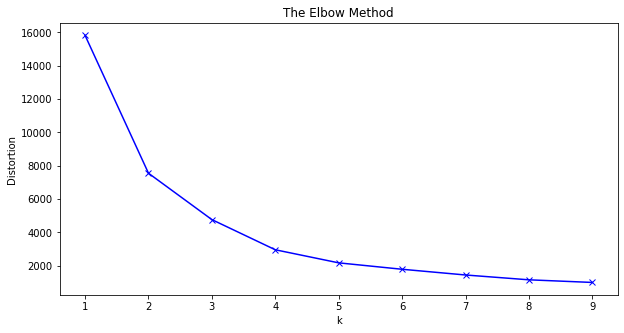

In [125]:
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

From the above plot it can be seen that distortion drops significantly with k=2, and moderately for k=3 or k=4. Beyond that, a larger number of clusters do not add much value. Hence, we may proceed with k=2 and cluster areas into **'Go'** and **'No Go'** categories.

In [130]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 0])

Let's add the cluster labels to the dataframe.

In [131]:
# add clustering labels
df_onehot_grouped.drop(columns='Cluster Label', inplace=True, errors='ignore')
df_onehot_grouped.insert(1, 'Cluster Label', kmeans.labels_)
df_onehot_grouped

Address  Cluster Label  Auto  \
0                       Ajmera, Haveli, Pune District              0     1   
1                               Ambad, Nashik, Nashik              1     5   
2                             Asoda, Jalgaon, Jalgaon              1     1   
3                     Baner, Pune City, Pune District              0     2   
4                      Bavdhan, Mulshi, Pune District              1     1   
5                       Bharat Nagar, Nagpur District              1     6   
6                        Brahmand Nagar, Thane, Thane              1     2   
7                    Chinchwad, Haveli, Pune District              0     1   
8                                 D Ward, Mumbai City              0     3   
9                           Dhantoli, Nagpur District              0     4   
10                Erandwana, Pune City, Pune District              0     1   
11                   Evershine Nagari, Vasai, Palghar              1     1   
12                              F/S Ward, Mumbai City              0     3   
13             Fatima Nagar, Pune City, Pune District              0     1   
14                       Gandhi Baug, Nagpur District              0     4   
15              Ganesh Peth, Pune City, Pune District              0     1   
16                          H/W Ward, Mumbai Suburban              0     6   
17                              Haveli, Pune District              1     1   
18                  K/W Ward, Kulāba, Mumbai Suburban              0     3   
19                          K/W Ward, Mumbai Suburban              0    18   
20                         Kapur Bawadi, Thane, Thane              0     3   
21                         Kasarvadavli, Thane, Thane              1     1   
22                           Kharghar, Panvel, Raigad              1     3   
23                        Kolhapur, Kolhapur district              0     4   
24                  Kothrud, Pune City, Pune District              0     2   
25                            L Ward, Mumbai Suburban              0    14   
26           Mandalay Lines, Pune City, Pune District              0     1   
27                             Miraj, Sangli district              1     1   
28             Model Colony, Pune City, Pune District              0     3   
29                         Mominpura, Nagpur District              0     2   
30                            N Ward, Mumbai Suburban              0     6   
31                 NH166, Kolhapur, Kolhapur district              0     1   
32                       NH65, Solapur North, Solapur              1     1   
33                       NH65, Solapur South, Solapur              1     1   
34                  Nagar Road, Haveli, Pune District              0     1   
35                                     Nashik, Nashik              0     3   
36                         New Panvel, Panvel, Raigad              1     4   
37  Old Bhandara Road, Nagpur Rural Taluka, Nagpur...              1     1   
38                          P/N Ward, Mumbai Suburban              0     2   
39                          P/S Ward, Mumbai Suburban              0     5   
40                           Pune City, Pune District              0     2   
41           Rajarampuri, Kolhapur, Kolhapur district              0     1   
42                        Ramdaspeth, Nagpur District              0     1   
43                            S Ward, Mumbai Suburban              0     8   
44                      Sadar Bazaar, Nagpur District              0     1   
45                              Sanpada, Thane, Thane              0     3   
46              Satara Road, Pune City, Pune District              0     1   
47                             Satpur, Nashik, Nashik              1     2   
48                    Seminary Hills, Nagpur District              1     1   
49                          Shree Nagar, Thane, Thane              0     3   
50                 Swargate, Pune City, Pune District              0

<a id='itemC'></a>

## C. Results and Discussion
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

From the above, it can be clearly seen that cluster 0 has venues from all categories of interest, and hence, is a **Go** cluster. On the other hand, cluster 1 is a **No Go** cluster as it has very few or no venues in either one or more categories of interest.

We need to add coordinates for each address so as to plot them on the map. We can get the addresses from the original *df_addresses* by performing a join operation.

In [132]:
# Join dfs to get geo-coordinates for each address
df_onehot_merged = pd.merge(df_onehot_grouped, df_addresses, how='outer', left_on='Address', right_on='address')

In [133]:
# Drop the 'address' column
df_onehot_merged.drop(['address'], axis=1)

Address  Cluster Label  Auto  \
0                       Ajmera, Haveli, Pune District              0     1   
1                               Ambad, Nashik, Nashik              1     5   
2                             Asoda, Jalgaon, Jalgaon              1     1   
3                     Baner, Pune City, Pune District              0     2   
4                      Bavdhan, Mulshi, Pune District              1     1   
5                       Bharat Nagar, Nagpur District              1     6   
6                        Brahmand Nagar, Thane, Thane              1     2   
7                    Chinchwad, Haveli, Pune District              0     1   
8                                 D Ward, Mumbai City              0     3   
9                           Dhantoli, Nagpur District              0     4   
10                Erandwana, Pune City, Pune District              0     1   
11                   Evershine Nagari, Vasai, Palghar              1     1   
12                              F/S Ward, Mumbai City              0     3   
13             Fatima Nagar, Pune City, Pune District              0     1   
14                       Gandhi Baug, Nagpur District              0     4   
15              Ganesh Peth, Pune City, Pune District              0     1   
16                          H/W Ward, Mumbai Suburban              0     6   
17                              Haveli, Pune District              1     1   
18                  K/W Ward, Kulāba, Mumbai Suburban              0     3   
19                          K/W Ward, Mumbai Suburban              0    18   
20                         Kapur Bawadi, Thane, Thane              0     3   
21                         Kasarvadavli, Thane, Thane              1     1   
22                           Kharghar, Panvel, Raigad              1     3   
23                        Kolhapur, Kolhapur district              0     4   
24                  Kothrud, Pune City, Pune District              0     2   
25                            L Ward, Mumbai Suburban              0    14   
26           Mandalay Lines, Pune City, Pune District              0     1   
27                             Miraj, Sangli district              1     1   
28             Model Colony, Pune City, Pune District              0     3   
29                         Mominpura, Nagpur District              0     2   
30                            N Ward, Mumbai Suburban              0     6   
31                 NH166, Kolhapur, Kolhapur district              0     1   
32                       NH65, Solapur North, Solapur              1     1   
33                       NH65, Solapur South, Solapur              1     1   
34                  Nagar Road, Haveli, Pune District              0     1   
35                                     Nashik, Nashik              0     3   
36                         New Panvel, Panvel, Raigad              1     4   
37  Old Bhandara Road, Nagpur Rural Taluka, Nagpur...              1     1   
38                          P/N Ward, Mumbai Suburban              0     2   
39                          P/S Ward, Mumbai Suburban              0     5   
40                           Pune City, Pune District              0     2   
41           Rajarampuri, Kolhapur, Kolhapur district              0     1   
42                        Ramdaspeth, Nagpur District              0     1   
43                            S Ward, Mumbai Suburban              0     8   
44                      Sadar Bazaar, Nagpur District              0     1   
45                              Sanpada, Thane, Thane              0     3   
46              Satara Road, Pune City, Pune District              0     1   
47                             Satpur, Nashik, Nashik              1     2   
48                    Seminary Hills, Nagpur District              1     1   
49                          Shree Nagar, Thane, Thane              0     3   
50                 Swargate, Pune City, Pune District              0

#### Map existing dealer locations to the above addresses

Out of the above addresses, we need to identify those where the company already has dealers present. For this, we can add a check column referring to *df_honda['dlr_address']*.

In [153]:
dlr = df_honda['dlr_address']

In [154]:
type(dlr)

pandas.core.series.Series

In [158]:
addcheck = []
for addr in df_onehot_merged['Address']:
    addcheck.append(addr in dlr.values)

print(addcheck)

[False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, True, False, True, False]


In [159]:
df_onehot_merged['DlrCheck'] = addcheck
df_onehot_merged.head()

Address  Cluster Label  Auto  Bank  Commercial  \
0    Ajmera, Haveli, Pune District              0     1     1           2   
1            Ambad, Nashik, Nashik              1     5     1           0   
2          Asoda, Jalgaon, Jalgaon              1     1     0           0   
3  Baner, Pune City, Pune District              0     2     3           6   
4   Bavdhan, Mulshi, Pune District              1     1     4           2   

   Hotel  Nightlife  Restaurant                          address   addr_lat  \
0     23         18           2    Ajmera, Haveli, Pune District  18.633712   
1     15         11           0            Ambad, Nashik, Nashik  19.949995   
2      0          0           0          Asoda, Jalgaon, Jalgaon  21.041181   
3     22         30           9  Baner, Pune City, Pune District  18.564243   
4      6         29           2   Bavdhan, Mulshi, Pune District  18.507420   

    addr_lng  DlrCheck  
0  73.814069     False  
1  73.743146     False  
2  75.606734      True  
3  73.776857     False  
4  73.767407      True

Finally, let's create a Folium map to plot the resulting clusters

In [186]:
# create map
map_clusters = folium.Map(location=[MH_latitude, MH_longitude], zoom_start=7)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, dlr in zip(df_onehot_merged['addr_lat'], df_onehot_merged['addr_lng'], df_onehot_merged['Address'], df_onehot_merged['Cluster Label'], df_onehot_merged['DlrCheck']):
    
    if dlr == True:
        kcolor = '#002080'
        label = folium.Popup(str(poi) + ', Honda Dealer', parse_html=True)
    elif cluster == 0:
        kcolor = '#009933'
        label = folium.Popup(str(poi) + ', Cluster ' + str(cluster) + ': Go', parse_html=True)
    else: 
        kcolor = '#A00000'
        label = folium.Popup(str(poi) + ', Cluster ' + str(cluster) + ': No Go', parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        legend=True,
        color=kcolor,
        fill=True,
        fill_color=kcolor,
        fill_opacity=0.7).add_to(map_clusters)

In [187]:
map_clusters

Let's try and add a legend to the above map

In [188]:
# Code credit: https://github.com/gabrielepinto
# Code source: https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd

from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#002080;opacity:0.7;'></span>Honda Dealer</li>
    <li><span style='background:#009933;opacity:0.7;'></span>Go</li>
    <li><span style='background:#A00000;opacity:0.7;'></span>No Go</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

map_clusters.get_root().add_child(macro)

map_clusters

#### To conclude, list all addresses where Honda can consider opening a dealership

In [205]:
df_final_addresses = df_onehot_merged[(df_onehot_merged['DlrCheck']==False) & (df_onehot_merged['Cluster Label']==0)]
df_final_addresses = df_final_addresses[['Address', 'addr_lat', 'addr_lng']]
df_final_addresses.reset_index(drop=True)

Address   addr_lat   addr_lng
0              Ajmera, Haveli, Pune District  18.633712  73.814069
1            Baner, Pune City, Pune District  18.564243  73.776857
2           Chinchwad, Haveli, Pune District  18.640355  73.791713
3                        D Ward, Mumbai City  18.959798  72.811909
4                  Dhantoli, Nagpur District  21.133944  79.080566
5        Erandwana, Pune City, Pune District  18.508749  73.831843
6                      F/S Ward, Mumbai City  18.997860  72.846624
7     Fatima Nagar, Pune City, Pune District  18.504510  73.902129
8               Gandhi Baug, Nagpur District  21.150010  79.102428
9      Ganesh Peth, Pune City, Pune District  18.515422  73.864737
10                 H/W Ward, Mumbai Suburban  19.065634  72.831947
11         K/W Ward, Kulāba, Mumbai Suburban  19.117702  72.833378
12                 K/W Ward, Mumbai Suburban  19.117702  72.833378
13                Kapur Bawadi, Thane, Thane  19.221207  72.985310
14               Kolhapur, Kolhapur district  16.702841  74.240533
15         Kothrud, Pune City, Pune District  18.503889  73.807673
16                   L Ward, Mumbai Suburban  19.088502  72.886695
17    Model Colony, Pune City, Pune District  18.531430  73.837451
18                Mominpura, Nagpur District  21.156141  79.096271
19                   N Ward, Mumbai Suburban  19.086812  72.921677
20         Nagar Road, Haveli, Pune District  18.563749  73.942425
21                            Nashik, Nashik  20.011247  73.790236
22                 P/N Ward, Mumbai Suburban  19.182127  72.847952
23                 P/S Ward, Mumbai Suburban  19.157745  72.851641
24                  Pune City, Pune District  18.525190  73.861824
25  Rajarampuri, Kolhapur, Kolhapur district  16.694377  74.245285
26               Ramdaspeth, Nagpur District  21.136585  79.074987
27                   S Ward, Mumbai Suburban  19.134822  72.925482
28             Sadar Bazaar, Nagpur District  21.163412  79.077390
29                     Sanpada, Thane, Thane  19.060734  73.011678
30                 Shree Nagar, Thane, Thane  19.189495  72.946172
31        Swargate, Pune City, Pune District  18.499818  73.856810
32                       Vashi, Thane, Thane  19.075784  72.995236
33              Wakad, Mulshi, Pune District  18.610902  73.763796
34         Ward 15, Pune City, Pune District  18.561284  73.895115

<a id='itemD'></a>

## D. Conclusion
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

We have successfully identified prospective locations for new Honda dealerships based on criteria like economic activity, availability of finance, and lifestyle. While applying this project in a real-life situation, additional data or approximation thereof regarding market size, rival dealer sales etc. will be valuable and should be added to the analysis.

*This notebook is created for the Capstone project for IBM's Data Science Professional Certification on Coursera for educational purpose. This project is not commissioned by or executed by Honda Cars India Ltd. The methodology and resources used are entirely based on discretion of the author and may not be the same as that followed by Honda or any other OEM.*

<hr>

Amol Sangeet; 2020. [GitHub](https://github.com/amolrs/Coursera_Capstone) | [LinkedIn](https://www.linkedin.com/in/amolsangeet/)